In [1]:
import os
os.chdir('..')

In [2]:
import json
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
from scipy.stats import ttest_ind, ranksums, pearsonr, spearmanr
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [3]:
plt.rcParams['font.family'] = 'DejaVu Serif'

In [4]:
def get_calendar_age_and_id(segment, age_data):
    test_id = segment.split('_')[0]
    target_numpy = age_data.loc[test_id].corrected_age
    return float(target_numpy), test_id

def create_dataframe(y_pred, segments, age_file):
    age_data = pd.read_csv(age_file, dtype={'test_id': str}).set_index('test_id')

    y_true, ids_val = zip(*[get_calendar_age_and_id(segment, age_data) for segment in segments])
    
    df_val = pd.DataFrame({
        'y_true': np.array(y_true),
        'y_pred': np.array(y_pred),
        'test_id': ids_val
    })

    return df_val

In [5]:
prediction_models = [
    'jb-aagcn-coord', 'jb-aagcn-coord-xy'
]

df_severe  = pd.DataFrame()

for model in prediction_models:
    file_path = f'predictions/{model}_predictions.csv'
    model_df = pd.read_csv(file_path)
    model_df['model'] = model
    df_severe  = pd.concat([df_severe, model_df], ignore_index=True)

df_severe.sample(frac=1).head()

,fold,test_id,y_true,y_pred,segment,outcome,model
872,6,0133,92,85.557610,0133_1_4,2.0,jb-aagcn-coord
2393,6,0091,52,61.492786,0091_3_2,2.0,jb-aagcn-coord-xy
2461,7,0059,34,71.133965,0059_1_3,2.0,jb-aagcn-coord-xy
1210,9,0003,90,80.564560,0003_1_2,2.0,jb-aagcn-coord
455,4,0003,90,80.443700,0003_1_2,2.0,jb-aagcn-coord


In [6]:
models = [
    'stgcn-kt3', 'stgcn-kt5', 'stgcn-kt7', 'stgcn-kt9', 'stgcn-kt11', 'stgcn-kt13', 'stgcn-kt15', 'stgcn-kt17', 
    'agcn', 'aagcn', 'aagcn-coord', 'aagcn-fc',
    'aagcn-coord', 'jb-aagcn-coord', 'jbv-aagcn-coord', 'jbva-aagcn-coord',
    'lr', 'rf', 'gb', 'xgb',
    'jb-aagcn-coord-raw-xy', 'jb-aagcn-coord-xy', 'jb-aagcn-coord-raw', 'jb-aagcn-coord', 'jb-aagcn-coord-fts'
]

df_val_all = pd.DataFrame()

age_file = Path('metadata', 'combined.csv')
fts_data = pd.read_csv('data/features.csv')

folds = [f'fold_{i}' for i in range(1, 11)]

for model_name in tqdm(models):
    model_dir = Path('results', model_name)

    for fold in folds:
        result_dir = Path(model_dir, fold)

        y_pred_val = np.load(Path(result_dir, 'val_predictions.npy'))

        with open(Path(result_dir, 'metadata.json'), 'r') as f:
            metadata = json.load(f)

        val_segments = metadata['val_segments']

        df_val = create_dataframe(y_pred_val, val_segments, age_file)

        df_val['fold'] = fold
        df_val['model'] = model_name
        if model_name not in ['lr', 'rf', 'gb', 'xgb']:
            df_val['params'] = metadata['params']
        else:
            df_val['params'] = 0

        df_val_all = pd.concat([df_val_all, df_val])

df_train_all = df_val_all.merge(fts_data[['test_id', 'outcome']], on='test_id', how='left')
df_val_all = df_val_all.merge(fts_data[['test_id', 'outcome']], on='test_id', how='left')

df_val_all['location'] = df_val_all['test_id'].apply(lambda x: 'Helsinki' if x.startswith('v') else 'Pisa')

df_val_all.sample(frac=1).head()

  0%|          | 0/25 [00:00<?, ?it/s]

,y_true,y_pred,test_id,fold,model,params,outcome,location
456661,85.0,88.370422,vv78,fold_7,jb-aagcn-coord-fts,3400902,0,Helsinki
365640,96.0,75.252129,0090,fold_5,jb-aagcn-coord-raw-xy,3396734,1,Pisa
222251,95.0,95.175095,v62,fold_2,aagcn-coord,3395290,1,Helsinki
304043,87.0,85.017792,v85,fold_10,jb-aagcn-coord,3399622,0,Helsinki
386028,88.0,87.493492,0016,fold_5,jb-aagcn-coord-xy,3396734,1,Pisa


In [7]:
print('num mni segments:', df_severe.segment.nunique())

num mni segments: 151


In [8]:
val_segments_all = []
model_name = 'aagcn'
model_dir = Path('results', model_name)

for fold in folds:
    result_dir = Path(model_dir, fold)
    with open(Path(result_dir, 'metadata.json'), 'r') as f:
        metadata = json.load(f)
    val_segments = metadata.get('val_segments', [])
    val_segments_all.extend(val_segments)

print('num typical segments:', len(val_segments_all))

num typical segments: 1692


## Calculate metrics

In [7]:
results_df_val = pd.DataFrame(columns=['Model', 'ME (days)', 'RMSE (days)', 'MAE (days)', 'CVME (%)', 'CVRMSE (%)', 'R2', 'Pearson', 'Spearman'])

for model in tqdm(models):
    model_df = df_val_all[df_val_all['model'] == model]

    # Lists to store metrics for each fold
    me_list, rmse_list, mae_list, r2_list, cvrmse_list, cvme_list, pearson_list, spearman_list = [], [], [], [], [], [], [], []

    # Iterate through each fold
    for fold in model_df['fold'].unique():
        fold_df = model_df[model_df['fold'] == fold]
        params = model_df.params.iloc[0]
        grouped_fold_df = fold_df.groupby('test_id').agg({'y_true': 'mean', 'y_pred': 'mean'}).reset_index()

        me = np.mean(grouped_fold_df['y_pred'] - grouped_fold_df['y_true'])
        rmse = mean_squared_error(grouped_fold_df['y_true'], grouped_fold_df['y_pred'], squared=False)
        # rmse = root_mean_squared_error(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])
        mae = mean_absolute_error(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])
        r2 = r2_score(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])

        y_true_mean = np.mean(grouped_fold_df['y_true'])
        cvme = (me / y_true_mean) * 100
        cvrmse = (rmse / y_true_mean) * 100

        pearson_corr, _ = pearsonr(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])
        spearman_corr, _ = spearmanr(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])

        me_list.append(me)
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)
        cvme_list.append(cvme)
        cvrmse_list.append(cvrmse)
        pearson_list.append(pearson_corr)
        spearman_list.append(spearman_corr)

    # Calculate mean and standard deviation for each metric
    me_mean, me_std = np.mean(me_list), np.std(me_list)
    rmse_mean, rmse_std = np.mean(rmse_list), np.std(rmse_list)
    mae_mean, mae_std = np.mean(mae_list), np.std(mae_list)
    cvme_mean, cvme_std = np.mean(cvme_list), np.std(cvme_list)
    cvrmse_mean, cvrmse_std = np.mean(cvrmse_list), np.std(cvrmse_list)
    r2_mean, r2_std = np.mean(r2_list), np.std(r2_list)
    pearson_mean, pearson_std = np.mean(pearson_list), np.std(pearson_list)
    spearman_mean, spearman_std = np.mean(spearman_list), np.std(spearman_list)

    # Create a new DataFrame row with results
    new_row = pd.DataFrame({
        'Model': [model],
        'Params': [params],
        'ME (days)': [(me_mean, me_std)],
        'RMSE (days)': [(rmse_mean, rmse_std)],
        'MAE (days)': [(mae_mean, mae_std)],
        'CVME (%)': [(cvme_mean, cvme_std)],
        'CVRMSE (%)': [(cvrmse_mean, cvrmse_std)],
        'R2': [(r2_mean, r2_std)],
        'Pearson': [(pearson_mean, pearson_std)],
        'Spearman': [(spearman_mean, spearman_std)],
    })
    results_df_val = pd.concat([results_df_val, new_row], ignore_index=True)

# Extract kt from stgcn-kt models and sort
stgcn_kt_df = results_df_val[results_df_val['Model'].str.contains('stgcn-kt')].copy()
stgcn_kt_df['kt'] = stgcn_kt_df['Model'].apply(lambda x: int(x.split('-kt')[-1]))
stgcn_kt_df = stgcn_kt_df.sort_values(by='kt')

# Extract mean and std for each metric
df_means = stgcn_kt_df.copy()
df_stds = stgcn_kt_df.copy()
for metric in ['ME (days)', 'RMSE (days)', 'MAE (days)', 'CVME (%)', 'CVRMSE (%)', 'R2', 'Pearson', 'Spearman']:
    df_means[metric] = stgcn_kt_df[metric].apply(lambda x: x[0])
    df_stds[metric] = stgcn_kt_df[metric].apply(lambda x: x[1])

  0%|          | 0/25 [00:00<?, ?it/s]

In [8]:
results_df_val_formatted = results_df_val.copy()
for metric in ['ME (days)', 'RMSE (days)', 'MAE (days)', 'CVME (%)', 'CVRMSE (%)', 'R2', 'Pearson', 'Spearman']:
    results_df_val_formatted[metric] = results_df_val_formatted[metric].apply(lambda x: f'{x[0]:.2f} ± {x[1]:.2f}')

results_df_val_formatted

,Model,ME (days),RMSE (days),MAE (days),CVME (%),CVRMSE (%),R2,Pearson,Spearman,Params
0,stgcn-kt3,-1.94 ± 4.41,17.56 ± 3.23,13.00 ± 2.76,-1.98 ± 4.73,19.27 ± 3.67,0.21 ± 0.21,0.53 ± 0.20,0.47 ± 0.25,1009645.0
1,stgcn-kt5,-0.57 ± 3.62,17.29 ± 3.24,12.50 ± 2.28,-0.52 ± 3.92,19.01 ± 3.83,0.23 ± 0.20,0.50 ± 0.18,0.41 ± 0.22,1402861.0
2,stgcn-kt7,-1.23 ± 3.72,17.08 ± 2.84,12.34 ± 2.39,-1.27 ± 4.14,18.82 ± 3.69,0.25 ± 0.18,0.55 ± 0.20,0.48 ± 0.21,1796077.0
3,stgcn-kt9,-2.37 ± 3.47,16.92 ± 2.79,12.75 ± 2.21,-2.46 ± 3.72,18.61 ± 3.45,0.27 ± 0.16,0.58 ± 0.14,0.45 ± 0.21,2189293.0
4,stgcn-kt11,-0.07 ± 2.47,16.81 ± 3.08,12.21 ± 2.18,0.02 ± 2.68,18.52 ± 3.91,0.28 ± 0.18,0.56 ± 0.18,0.48 ± 0.15,2582509.0
5,stgcn-kt13,0.22 ± 3.76,16.76 ± 2.53,12.29 ± 1.91,0.35 ± 4.01,18.46 ± 3.38,0.28 ± 0.18,0.56 ± 0.19,0.50 ± 0.20,2975725.0
6,stgcn-kt15,0.41 ± 2.41,16.78 ± 3.04,12.08 ± 2.47,0.54 ± 2.60,18.46 ± 3.69,0.28 ± 0.19,0.54 ± 0.18,0.50 ± 0.19,3368941.0
7,stgcn-kt17,-0.11 ± 3.56,16.80 ± 2.93,12.44 ± 2.12,0.01 ± 3.89,18.51 ± 3.75,0.28 ± 0.17,0.56 ± 0.15,0.44 ± 0.21,3762157.0
8,agcn,0.60 ± 2.95,16.67 ± 3.09,12.42 ± 2.46,0.71 ± 3.18,18.32 ± 3.64,0.29 ± 0.18,0.58 ± 0.15,0.43 ± 0.26,3177556.0
9,aagcn,-0.54 ± 2.69,16.46 ± 2.53,12.29 ± 1.35,-0.52 ± 2.96,18.14 ± 3.41,0.30 ± 0.19,0.56 ± 0.19,0.45 ± 0.23,3395290.0


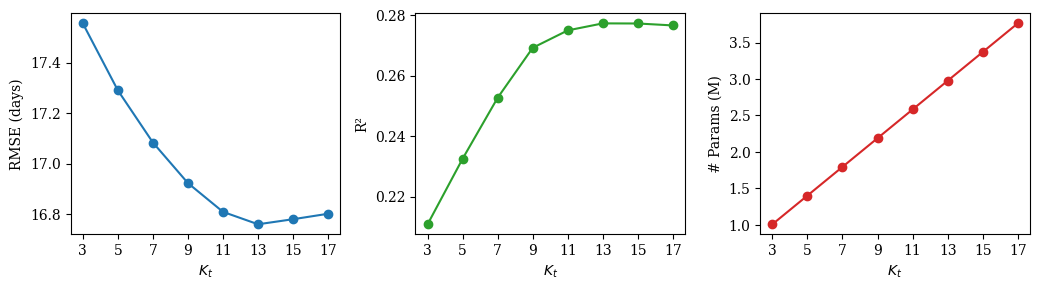

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10.5, 3))

# First subplot for RMSE
ax1.set_xlabel(r'$K_t$')
ax1.set_ylabel('RMSE (days)')
ax1.plot(stgcn_kt_df['kt'], df_means['RMSE (days)'], marker='o', color='tab:blue', label='RMSE (days)')
ax1.set_xticks(stgcn_kt_df['kt'])
ax1.set_xticklabels(stgcn_kt_df['kt'])

# Second subplot for R²
ax2.set_xlabel(r'$K_t$')
ax2.set_ylabel('R²')
ax2.plot(stgcn_kt_df['kt'], df_means['R2'], marker='o', color='tab:green', label='R²')
ax2.set_xticks(stgcn_kt_df['kt'])
ax2.set_xticklabels(stgcn_kt_df['kt'])

# Third subplot for Params
ax3.set_xlabel(r'$K_t$')
ax3.set_ylabel('# Params (M)')
ax3.plot(stgcn_kt_df['kt'], stgcn_kt_df['Params'] / 1e6, marker='o', color='tab:red', label='Params')
ax3.set_xticks(stgcn_kt_df['kt'])
ax3.set_xticklabels(stgcn_kt_df['kt'])

# Adjust layout
fig.tight_layout()
for ext in ['png', 'pdf']:
    plt.savefig(f'figures/kt.{ext}', dpi=300)
plt.show()

## Results by Location

In [9]:
# Group by location and test_id to get unique test_id counts and calculate statistics for y_true
all_stats = df_val_all.groupby('test_id').agg({'y_true': ['mean', 'std', 'count']}).reset_index()

# Calculate the number of unique test_ids, mean and std for y_true for both locations
all_summary = {
    'samples': all_stats['test_id'].nunique(),
    'mean_y_true': round(all_stats[('y_true', 'mean')].mean(), 2),
    'std_y_true': round(all_stats[('y_true', 'mean')].std(), 2),
    'min_y_true': round(all_stats[('y_true', 'mean')].min(), 2),
    'max_y_true': round(all_stats[('y_true', 'mean')].max(), 2)
}

print('normal:', all_summary)

# Group by location and test_id to get unique test_id counts and calculate statistics for y_true
all_stats = df_severe.groupby('test_id').agg({'y_true': ['mean', 'std', 'count']}).reset_index()

# Calculate the number of unique test_ids, mean and std for y_true for both locations
all_summary = {
    'samples': all_stats['test_id'].nunique(),
    'mean_y_true': round(all_stats[('y_true', 'mean')].mean(), 2),
    'std_y_true': round(all_stats[('y_true', 'mean')].std(), 2),
    'min_y_true': round(all_stats[('y_true', 'mean')].min(), 2),
    'max_y_true': round(all_stats[('y_true', 'mean')].max(), 2)
}

print('severe:', all_summary)

normal: {'samples': 159, 'mean_y_true': 91.5, 'std_y_true': 21.0, 'min_y_true': 27.0, 'max_y_true': 158.0}
severe: {'samples': 14, 'mean_y_true': 86.64, 'std_y_true': 30.39, 'min_y_true': 34.0, 'max_y_true': 143.0}


In [10]:
# Group by location and test_id to get unique test_id counts and calculate statistics for y_true
pisa_stats = df_val_all[df_val_all['location'] == 'Pisa'].groupby('test_id').agg({'y_true': ['mean', 'std', 'count']}).reset_index()
helsinki_stats = df_val_all[df_val_all['location'] == 'Helsinki'].groupby('test_id').agg({'y_true': ['mean', 'std', 'count']}).reset_index()

# Calculate the number of unique test_ids, mean and std for y_true for both locations
pisa_summary = {
    'samples': pisa_stats['test_id'].nunique(),
    'mean_y_true': round(pisa_stats[('y_true', 'mean')].mean(), 2),
    'std_y_true': round(pisa_stats[('y_true', 'mean')].std(), 2)
}

helsinki_summary = {
    'samples': helsinki_stats['test_id'].nunique(),
    'mean_y_true': round(helsinki_stats[('y_true', 'mean')].mean(), 2),
    'std_y_true': round(helsinki_stats[('y_true', 'mean')].std(), 2)
}

print('normal pisa:', pisa_summary)
print('normal helsinki:', helsinki_summary)

normal pisa: {'samples': 97, 'mean_y_true': 85.86, 'std_y_true': 22.23}
normal helsinki: {'samples': 62, 'mean_y_true': 100.32, 'std_y_true': 15.31}


In [11]:
# Filtering the df_val_all over y_true > 80 and recalculating the statistics
filtered_pisa_stats = df_val_all[(df_val_all['location'] == 'Pisa') & (df_val_all['y_true'] > 80)].groupby('test_id').agg({'y_true': ['mean', 'std', 'count']}).reset_index()
filtered_helsinki_stats = df_val_all[(df_val_all['location'] == 'Helsinki') & (df_val_all['y_true'] > 80)].groupby('test_id').agg({'y_true': ['mean', 'std', 'count']}).reset_index()

# Calculate the number of unique test_ids, mean and std for y_true > 80 for both locations
filtered_pisa_summary = {
    'samples': filtered_pisa_stats['test_id'].nunique(),
    'mean_y_true': round(filtered_pisa_stats[('y_true', 'mean')].mean(), 2),
    'std_y_true': round(filtered_pisa_stats[('y_true', 'mean')].std(), 2)
}

filtered_helsinki_summary = {
    'samples': filtered_helsinki_stats['test_id'].nunique(),
    'mean_y_true': round(filtered_helsinki_stats[('y_true', 'mean')].mean(), 2),
    'std_y_true': round(filtered_helsinki_stats[('y_true', 'mean')].std(), 2)
}

print('normal pisa > 80 days:', filtered_pisa_summary)
print('normal helsinki > 80 days:', filtered_helsinki_summary)

normal pisa > 80 days: {'samples': 74, 'mean_y_true': 96.18, 'std_y_true': 10.44}
normal helsinki > 80 days: {'samples': 59, 'mean_y_true': 101.42, 'std_y_true': 14.86}


### Metrics by Location

In [13]:
results_df_val = pd.DataFrame(columns=['Model', 'Location', 'RMSE (days)', 'R2', 'Pearson', 'Spearman'])

for model in tqdm(prediction_models):
    model_df = df_val_all[df_val_all['model'] == model]

    # Iterate through each location
    for location in ['Helsinki', 'Pisa']:
        location_df = model_df[model_df['location'] == location]

        me_list, rmse_list, mae_list, r2_list, cvrmse_list, cvme_list, pearson_list, spearman_list = [], [], [], [], [], [], [], []

        # Iterate through each fold within the location
        for fold in location_df['fold'].unique():
            fold_df = location_df[location_df['fold'] == fold]
            params = model_df['params'].iloc[0]
            grouped_fold_df = fold_df.groupby('test_id').agg({'y_true': 'mean', 'y_pred': 'mean'}).reset_index()

            rmse = mean_squared_error(grouped_fold_df['y_true'], grouped_fold_df['y_pred'], squared=False)
            r2 = r2_score(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])

            y_true_mean = np.mean(grouped_fold_df['y_true'])

            pearson_corr, _ = pearsonr(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])
            spearman_corr, _ = spearmanr(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])

            me_list.append(me)
            rmse_list.append(rmse)
            mae_list.append(mae)
            r2_list.append(r2)
            pearson_list.append(pearson_corr)
            spearman_list.append(spearman_corr)

        # Calculate mean and standard deviation for each metric
        rmse_mean, rmse_std = np.mean(rmse_list), np.std(rmse_list)
        r2_mean, r2_std = np.mean(r2_list), np.std(r2_list)
        pearson_mean, pearson_std = np.mean(pearson_list), np.std(pearson_list)
        spearman_mean, spearman_std = np.mean(spearman_list), np.std(spearman_list)

        new_row = pd.DataFrame({
            'Model': [model],
            'Location': [location],    
            'RMSE (days)': [f'{rmse_mean:.2f} ± {rmse_std:.2f}'], 
            'R2': [f'{r2_mean:.2f} ± {r2_std:.2f}'],
            'Pearson': [f'{pearson_mean:.2f} ± {pearson_std:.2f}'],
            'Spearman': [f'{spearman_mean:.2f} ± {spearman_std:.2f}'],
            
        })

        results_df_val = pd.concat([results_df_val, new_row], ignore_index=True)
    
results_df_val

  0%|          | 0/2 [00:00<?, ?it/s]

,Model,Location,RMSE (days),R2,Pearson,Spearman
0,jb-aagcn-coord,Helsinki,10.86 ± 3.11,-0.04 ± 0.83,0.51 ± 0.40,0.36 ± 0.42
1,jb-aagcn-coord,Pisa,17.89 ± 4.73,0.23 ± 0.26,0.54 ± 0.27,0.45 ± 0.24
2,jb-aagcn-coord-xy,Helsinki,13.20 ± 3.29,-0.56 ± 1.40,0.18 ± 0.54,0.14 ± 0.40
3,jb-aagcn-coord-xy,Pisa,18.61 ± 3.57,0.17 ± 0.18,0.52 ± 0.18,0.48 ± 0.28


### Metrics by Location > 80 days

In [14]:
results_df_val = pd.DataFrame(columns=['Model', 'Location', 'RMSE (days)', 'R2', 'Pearson', 'Spearman'])

for model in tqdm(prediction_models):
    model_df = df_val_all[df_val_all['model'] == model]

    # Iterate through each location
    for location in ['Helsinki', 'Pisa']:
        location_df = model_df[model_df['location'] == location]

        # Filter to only include infants with y_true > 80 days
        location_df = location_df[location_df['y_true'] > 80]

        rmse_list, r2_list, pearson_list, spearman_list = [], [], [], []

        # Iterate through each fold within the location
        for fold in location_df['fold'].unique():
            fold_df = location_df[location_df['fold'] == fold]
            grouped_fold_df = fold_df.groupby('test_id').agg({'y_true': 'mean', 'y_pred': 'mean'}).reset_index()

            rmse = mean_squared_error(grouped_fold_df['y_true'], grouped_fold_df['y_pred'], squared=False)
            r2 = r2_score(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])
            pearson_corr, _ = pearsonr(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])
            spearman_corr, _ = spearmanr(grouped_fold_df['y_true'], grouped_fold_df['y_pred'])

            rmse_list.append(rmse)
            r2_list.append(r2)
            pearson_list.append(pearson_corr)
            spearman_list.append(spearman_corr)

        # Calculate mean and standard deviation for each metric
        rmse_mean, rmse_std = np.mean(rmse_list), np.std(rmse_list)
        r2_mean, r2_std = np.mean(r2_list), np.std(r2_list)
        pearson_mean, pearson_std = np.mean(pearson_list), np.std(pearson_list)
        spearman_mean, spearman_std = np.mean(spearman_list), np.std(spearman_list)

        new_row = pd.DataFrame({
            'Model': [model],
            'Location': [location],    
            'RMSE (days)': [f'{rmse_mean:.2f} ± {rmse_std:.2f}'], 
            'R2': [f'{r2_mean:.2f} ± {r2_std:.2f}'],
            'Pearson': [f'{pearson_mean:.2f} ± {pearson_std:.2f}'],
            'Spearman': [f'{spearman_mean:.2f} ± {spearman_std:.2f}'],
        })

        results_df_val = pd.concat([results_df_val, new_row], ignore_index=True)

results_df_val

  0%|          | 0/2 [00:00<?, ?it/s]

,Model,Location,RMSE (days),R2,Pearson,Spearman
0,jb-aagcn-coord,Helsinki,10.83 ± 3.17,-0.05 ± 0.83,0.52 ± 0.41,0.37 ± 0.42
1,jb-aagcn-coord,Pisa,10.85 ± 4.27,-0.70 ± 1.07,0.29 ± 0.31,0.25 ± 0.22
2,jb-aagcn-coord-xy,Helsinki,13.22 ± 3.88,-0.59 ± 1.41,0.20 ± 0.56,0.18 ± 0.45
3,jb-aagcn-coord-xy,Pisa,11.57 ± 4.09,-1.46 ± 2.69,0.27 ± 0.46,0.29 ± 0.43


## Predicted vs Ground Truth Plot

- Pearson's Correlation Coefficient (r): This measures the linear correlation between the predicted and actual values. A value closer to 1 indicates a strong positive correlation.
- P-value for Pearson's Correlation: This tests the hypothesis of no correlation between predicted and actual values. A low p-value (typically < 0.05) indicates that the correlation is statistically significant.

## Bland-Altman Plot

- Mean Bias: The average difference between the predicted and actual values. It gives an idea of whether the predictions are consistently higher or lower than the actual values.
- Limits of Agreement: Typically calculated as the mean bias ± 1.96 times the standard deviation of the differences. This interval estimates where 95% of the differences between predicted and actual values lie.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


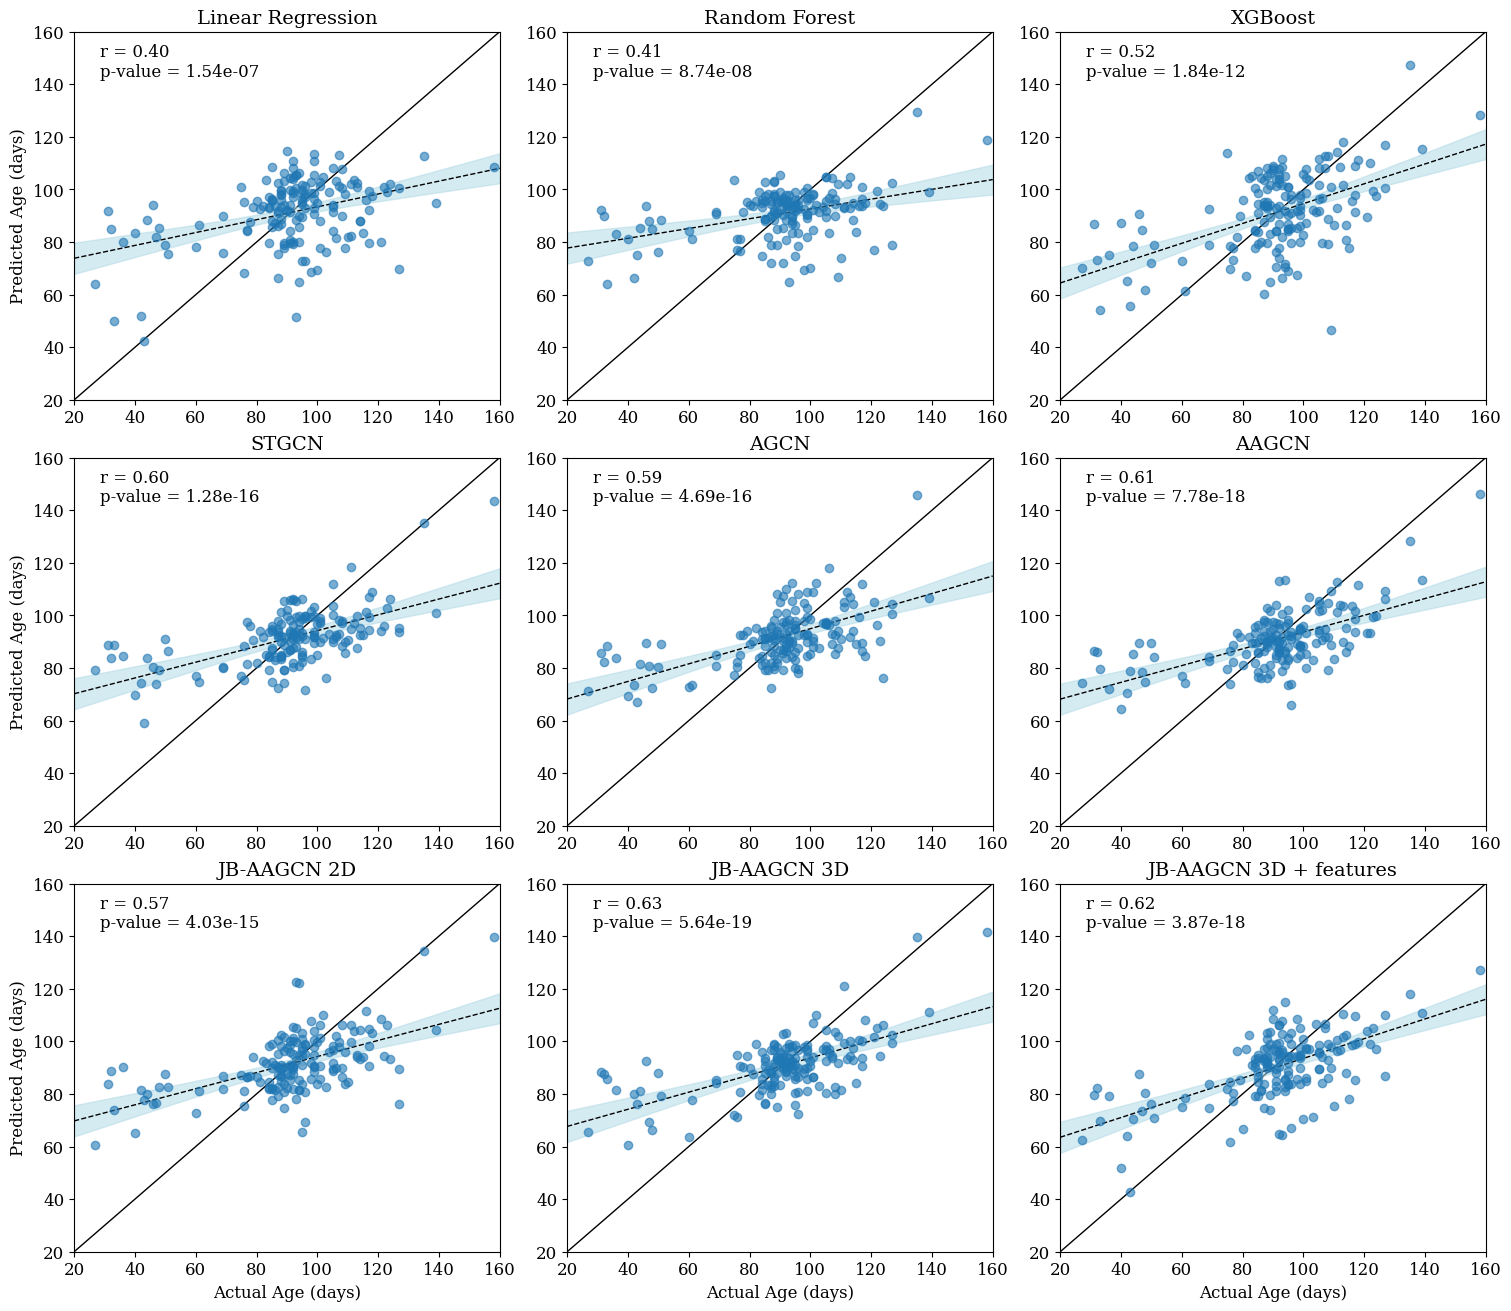

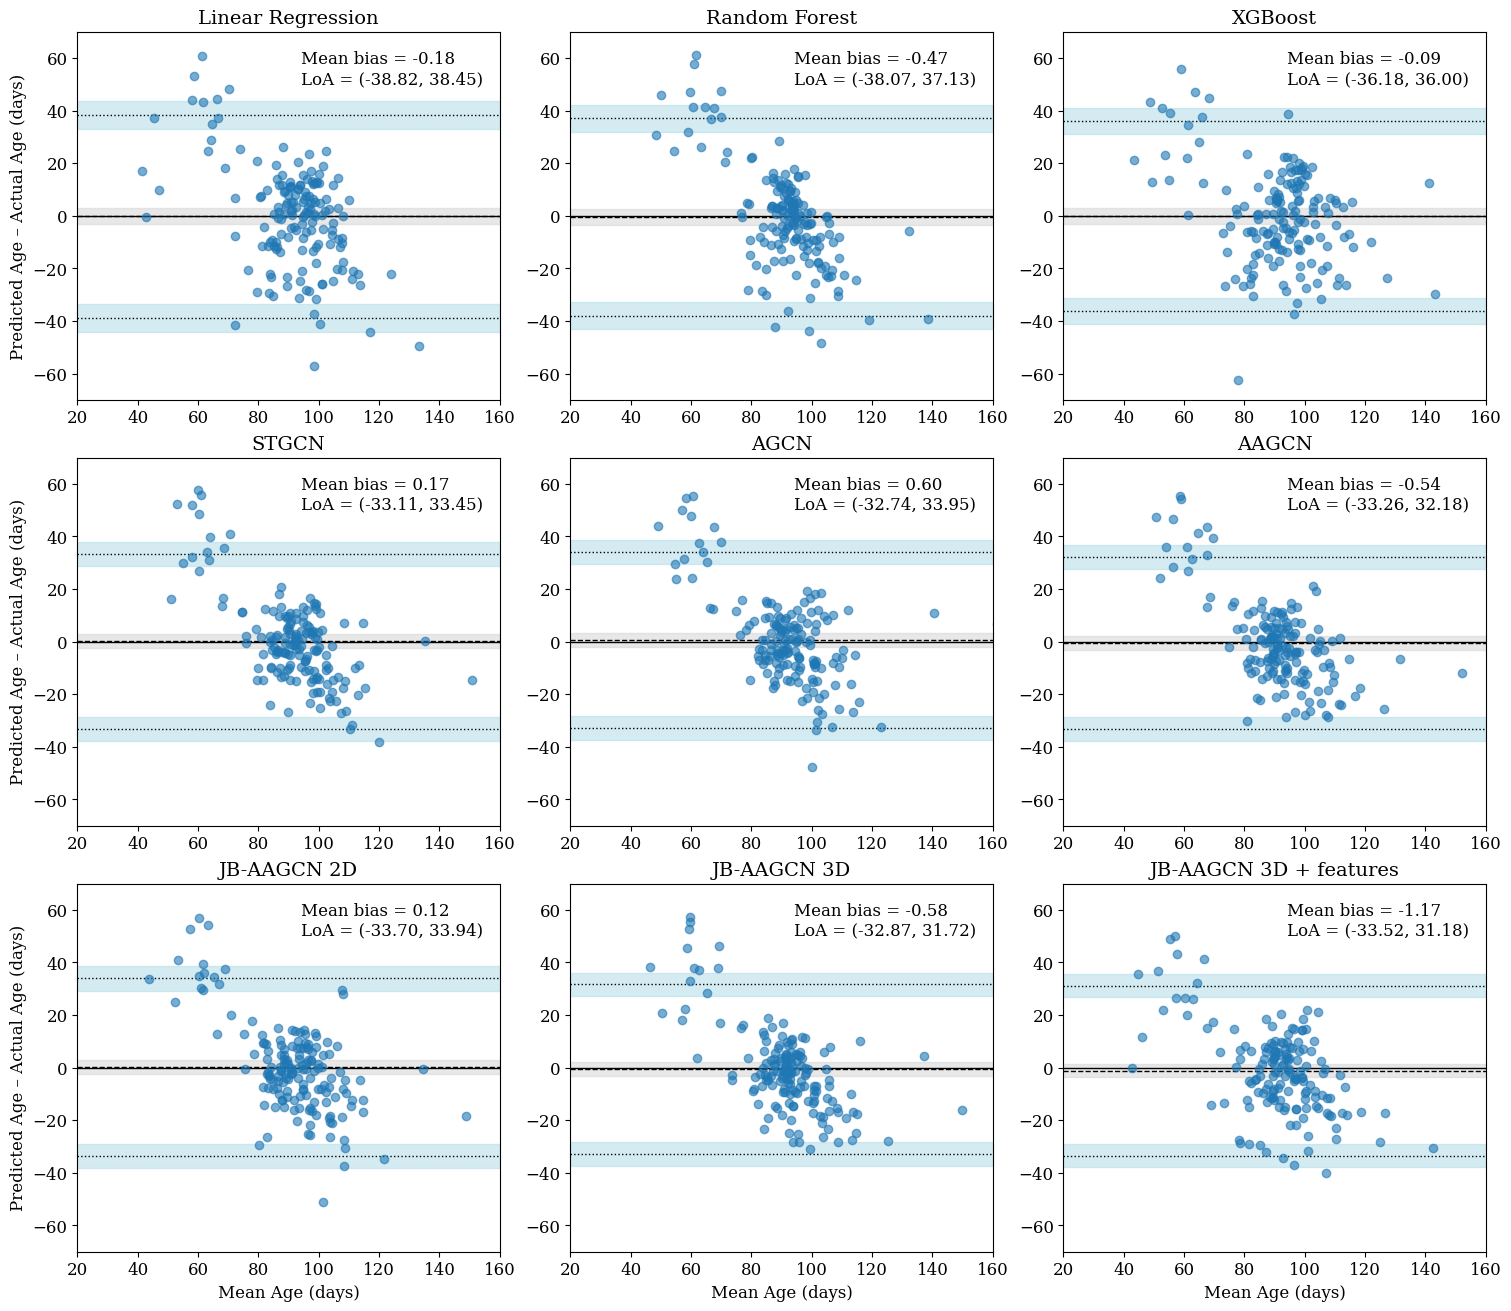

In [12]:
selected_models = [
    'lr', 'rf', 'xgb',
    'stgcn-kt13', 'agcn', 'aagcn',
    'jb-aagcn-coord-xy', 'jb-aagcn-coord', 'jb-aagcn-coord-fts'
]
model_names = [
    'Linear Regression', 'Random Forest', 'XGBoost',
    'STGCN', 'AGCN', 'AAGCN',
    'JB-AAGCN 2D', 'JB-AAGCN 3D', 'JB-AAGCN 3D + features'
]

# Define fixed xlim and ylim
x_limits = [20, 160]
y_limits = [20, 160]

# Create figures and axes for the subplots
fig1, axes1 = plt.subplots(3, 3, figsize=(15, 13), constrained_layout=True)
fig2, axes2 = plt.subplots(3, 3, figsize=(15, 13), constrained_layout=True)


# Flatten axes for easy iteration
axes1 = axes1.flatten()
axes2 = axes2.flatten()

for i, model in enumerate(selected_models):
    model_df = df_val_all[df_val_all['model'] == model]
    grouped_df = model_df.groupby('test_id').agg({
        'y_true': ['mean', 'std'], 
        'y_pred': ['mean', 'std'], 
        'outcome': 'first',
        'location': 'first'
    }).reset_index(drop=True)
    
    predictions = grouped_df[('y_pred', 'mean')]
    actual = grouped_df[('y_true', 'mean')]
    average = (predictions + actual) / 2
    difference = predictions - actual
    
    # Calculate Pearson correlation for Predicted vs Ground Truth Plot
    r, p_value = stats.pearsonr(actual, predictions)
    
    # Predicted vs Ground Truth Plot
    ax = axes1[i]
    a, b = np.polyfit(actual, predictions, deg=1)
    x_fit = np.linspace(x_limits[0], x_limits[1], 100)
    y_fit = a * x_fit + b
    
    x_mean = np.mean(actual)
    x_var = np.sum((actual - x_mean) ** 2)
    y_err_fit = actual.std() * np.sqrt(1/len(actual) + (x_fit - x_mean)**2 / x_var)
    
    ax.plot(x_fit, y_fit, '--', color='k', lw=1, zorder=2)
    ax.fill_between(x_fit, y_fit - y_err_fit, y_fit + y_err_fit, color='lightblue', alpha=0.5, zorder=1)
    ax.axline((0, 0), slope=1, color='k', lw=1, ls='-', zorder=0)
    ax.scatter(actual, predictions, c='tab:blue', alpha=0.6, zorder=3)
    
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    
    # Set labels and titles with specified font size
    if i % 3 == 0:  # y-label only on leftmost subplots
        ax.set_ylabel('Predicted Age (days)', fontsize=12)
    if i >= 6:  # x-label only on bottom subplots
        ax.set_xlabel('Actual Age (days)', fontsize=12)
        
    ax.text(0.06, 0.88, f'r = {r:.2f}\np-value = {p_value:.2e}', transform=ax.transAxes, fontsize=12)
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    ax.set_title(model_names[i], fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Bland-Altman Plot
    ax = axes2[i]
    mean_bias = difference.mean()
    limits_of_agreement = [mean_bias - 1.96 * difference.std(), mean_bias + 1.96 * difference.std()]

    # Standard error of the mean for the bias
    diff_std_error = difference.std() / np.sqrt(len(difference))
    # 95% CI for the mean bias
    mean_ci = [mean_bias - 1.96 * diff_std_error, mean_bias + 1.96 * diff_std_error]

    # Standard error for LoA
    s = difference.std()
    n = len(difference)
    loa_std_error = s * np.sqrt(3 / n)
    loa_ci_down = [limits_of_agreement[0] - 1.96 * loa_std_error, limits_of_agreement[0] + 1.96 * loa_std_error]
    loa_ci_up = [limits_of_agreement[1] - 1.96 * loa_std_error, limits_of_agreement[1] + 1.96 * loa_std_error]
    
    ax.fill_between([x_limits[0], x_limits[1]], mean_ci[0], mean_ci[1], color='lightgray', alpha=0.5, zorder=0)
    ax.fill_between([x_limits[0], x_limits[1]], loa_ci_down[0], loa_ci_down[1], color='lightblue', alpha=0.5, zorder=0)
    ax.fill_between([x_limits[0], x_limits[1]], loa_ci_up[0], loa_ci_up[1], color='lightblue', alpha=0.5, zorder=0)
    ax.axhline(0, color='black', ls='-', lw=1, zorder=0)
    ax.axhline(mean_bias, color='k', ls='--', lw=1, zorder=0)
    ax.axhline(limits_of_agreement[0], color='k', ls=':', lw=1, zorder=0)
    ax.axhline(limits_of_agreement[1], color='k', ls=':', lw=1, zorder=0)
    ax.scatter(average, difference, alpha=0.6, zorder=1)
    
    ax.set_xlim(x_limits)
    ax.set_ylim([-70, 70])
    
    # Set labels and titles with specified font size
    if i % 3 == 0:  # y-label only on leftmost subplots
        ax.set_ylabel('Predicted Age – Actual Age (days)', fontsize=12)
    if i >= 6:  # x-label only on bottom subplots
        ax.set_xlabel('Mean Age (days)', fontsize=12)
        
    ax.text(0.53, 0.86, f'Mean bias = {mean_bias:.2f}\nLoA = ({limits_of_agreement[0]:.2f}, {limits_of_agreement[1]:.2f})', transform=ax.transAxes, fontsize=12)
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    ax.set_title(model_names[i], fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)


for ext in ['png', 'pdf', 'eps']:
    fig1.savefig(f'figures/scatter_comparison.{ext}', dpi=300)
    fig2.savefig(f'figures/bland_altman_comparison.{ext}', dpi=300)

plt.show()

## Kinetic Age

In [10]:
# Functions to fit a sigmoid to the data
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

def fit_sigmoid(x, y):
    # Initial guess for the parameters [L, x0, k, b]
    p0 = [max(y), np.median(x), 0.01, min(y)]
    try:
        popt, _ = opt.curve_fit(sigmoid, x, y, p0, method='trf', maxfev=10000)
        return popt
    except RuntimeError as e:
        print(f"Sigmoid fitting failed: {e}")
        return None

def convert_to_ka(y_values, min_val=50, max_val=150, new_min=0, new_max=100):
    return (y_values - min_val) / (max_val - min_val) * (new_max - new_min) + new_min

Processing model: jb-aagcn-coord-xy
Subjects > 80 days - T-test 2.1036 p-value: 0.0372
Subjects > 80 days - Wilcoxon rank-sum test 1.9393 p-value: 0.0525
Processing model: jb-aagcn-coord
Subjects > 80 days - T-test 2.8220 p-value: 0.0055
Subjects > 80 days - Wilcoxon rank-sum test 2.2639 p-value: 0.0236


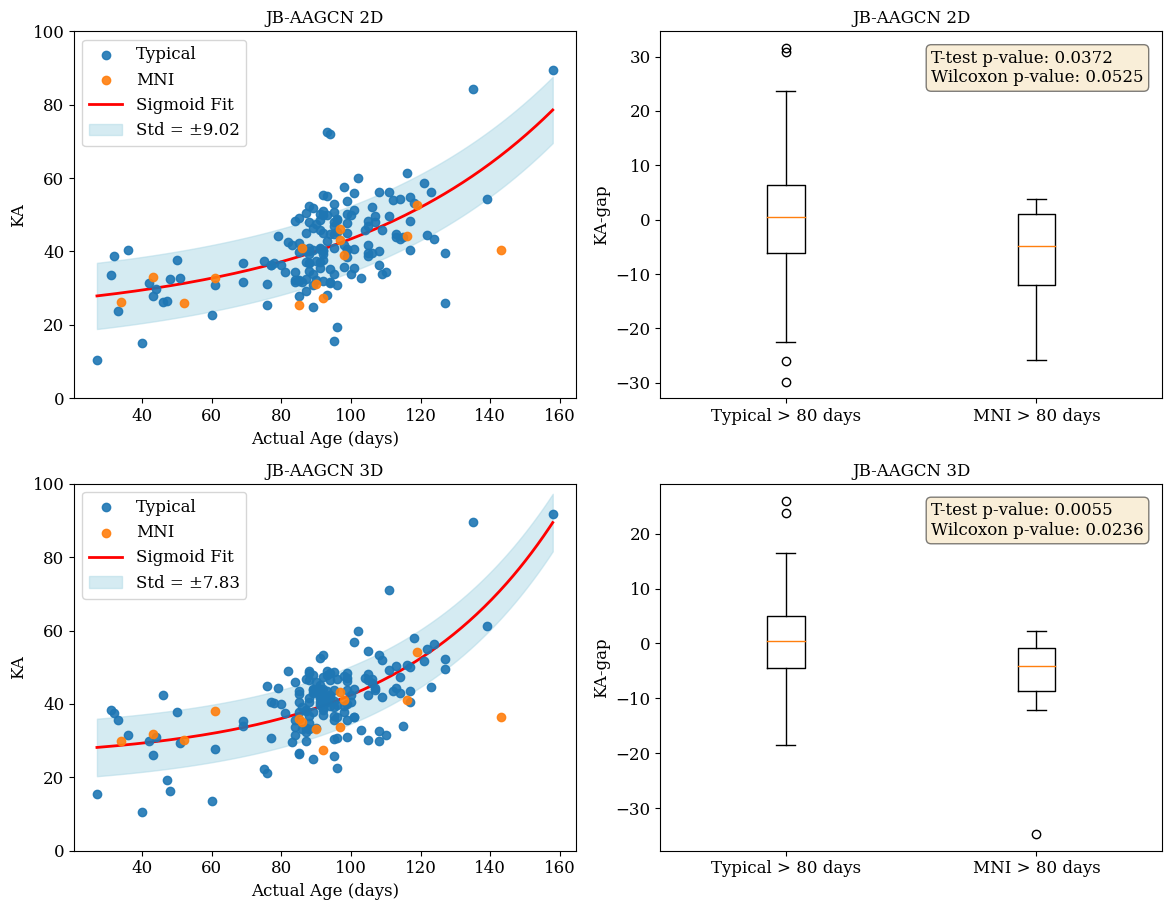

In [9]:
names = {'jb-aagcn-coord-xy': 'JB-AAGCN 2D', 'jb-aagcn-coord': 'JB-AAGCN 3D'}    

fig, axes = plt.subplots(2, 2, figsize=(12, 9.2))

for i, model in enumerate(['jb-aagcn-coord-xy', 'jb-aagcn-coord']):
    print(f"Processing model: {model}")
    
    model_df = df_val_all[df_val_all['model'] == model]
    grouped_df = model_df.groupby('test_id').agg({'y_true': ['mean'], 'y_pred': ['mean'], 'outcome': 'first'}).reset_index(drop=True)

    severe_df = df_severe[df_severe['model'] == model]
    grouped_severe_df = severe_df.groupby('test_id').agg({'y_true': 'mean', 'y_pred': 'mean', 'outcome': 'first'}).reset_index(drop=True)

    # Fit sigmoid to typical development data
    x_normal = grouped_df[('y_true', 'mean')]
    y_normal = grouped_df[('y_pred', 'mean')]
    sigmoid_params = fit_sigmoid(x_normal, y_normal)
    L, x0, k, b = sigmoid_params
    
    # Calculate residuals for normal group
    y_sigmoid_normal = sigmoid(x_normal, *sigmoid_params)
    
    # Calculate residuals for severe group
    x_severe = grouped_severe_df['y_true']
    y_severe = grouped_severe_df['y_pred']

    # Filter normal and severe subjects with actual corrected age > 80 days
    normal_over_80 = grouped_df[grouped_df[('y_true', 'mean')] > 80]
    severe_over_80 = grouped_severe_df[grouped_severe_df['y_true'] > 80]

    if not severe_over_80.empty and not normal_over_80.empty:
        residuals_normal_over_80 = (
            convert_to_ka(normal_over_80[('y_pred', 'mean')]) - \
            convert_to_ka(sigmoid(normal_over_80[('y_true', 'mean')], *sigmoid_params))
        )
        residuals_severe_over_80 = (
            convert_to_ka(severe_over_80['y_pred']) - \
            convert_to_ka(sigmoid(severe_over_80['y_true'], *sigmoid_params))
        )

        # Perform unpaired t-test and Wilcoxon rank-sum test for subjects over 80 days
        t_stat_80, t_pvalue_80 = ttest_ind(residuals_normal_over_80, residuals_severe_over_80)
        rank_stat_80, rank_pvalue_80 = ranksums(residuals_normal_over_80, residuals_severe_over_80)

        print(f"Subjects > 80 days - T-test {t_stat_80:.4f} p-value: {t_pvalue_80:.4f}")
        print(f"Subjects > 80 days - Wilcoxon rank-sum test {rank_stat_80:.4f} p-value: {rank_pvalue_80:.4f}")

        # Kinetic Age vs Corrected Age plot
        ax1 = axes[i, 0]
        ax1.scatter(grouped_df[('y_true', 'mean')], convert_to_ka(grouped_df[('y_pred', 'mean')]), alpha=0.9, label='Typical', zorder=3)
        ax1.scatter(grouped_severe_df['y_true'], convert_to_ka(grouped_severe_df['y_pred']), alpha=0.9, label='MNI', zorder=4)

        # Plot the fitted sigmoid curve
        x_vals = np.linspace(min(x_normal), max(x_normal), 300)
        y_vals = convert_to_ka(sigmoid(x_vals, *sigmoid_params))
        ax1.plot(x_vals, y_vals, color='red', label=f'Sigmoid Fit', linewidth=2, zorder=1)

        # Fill the area representing the standard deviation
        std_normal = np.std(convert_to_ka(y_normal) - convert_to_ka(y_sigmoid_normal))
        ax1.fill_between(x_vals, y_vals - std_normal, y_vals + std_normal, color='lightblue', alpha=0.5, label=f'Std = ±{std_normal:.2f}', zorder=0)

        # Labels and legend
        ax1.set_ylim([0, 100])
        ax1.tick_params(axis='both', which='major', labelsize=12)
        ax1.set_xlabel('Actual Age (days)', fontsize=12)
        ax1.set_ylabel('KA', fontsize=12)
        ax1.legend(loc='upper left', fontsize=12)
        ax1.set_title(names[model])

        # Boxplot of residuals for normal vs severe subjects > 80 days in second column
        ax2 = axes[i, 1]
        ax2.boxplot([residuals_normal_over_80, residuals_severe_over_80], labels=['Typical > 80 days', 'MNI > 80 days'])
        ax2.set_ylabel('KA-gap', fontsize=12)
        ax2.tick_params(axis='both', which='major', labelsize=12)
        ax2.set_title(names[model])

        textstr_80 = f'T-test p-value: {t_pvalue_80:.4f}\nWilcoxon p-value: {rank_pvalue_80:.4f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax2.text(0.54, 0.95, textstr_80, transform=ax2.transAxes,
                 verticalalignment='top', bbox=props, fontsize=12)

plt.tight_layout()
for ext in ['png', 'pdf']:
    plt.savefig(f'figures/predictions.{ext}', dpi=300)
plt.show()

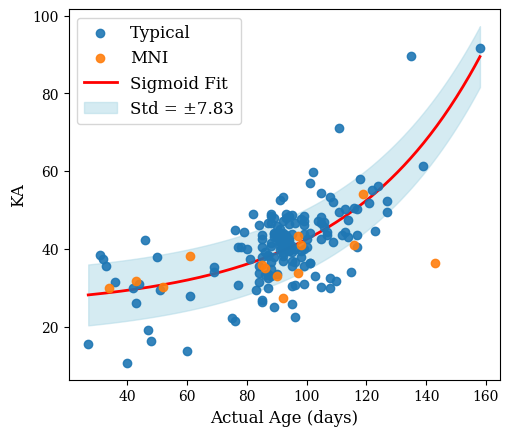

In [20]:
model_name = 'jb-aagcn-coord'
model_label = 'JB-AAGCN 3D'

# Filter the data for the selected model
model_df = df_val_all[df_val_all['model'] == model_name]
grouped_df = model_df.groupby('test_id').agg({'y_true': ['mean'], 'y_pred': ['mean'], 'outcome': 'first'}).reset_index(drop=True)

severe_df = df_severe[df_severe['model'] == model_name]
grouped_severe_df = severe_df.groupby('test_id').agg({'y_true': 'mean', 'y_pred': 'mean', 'outcome': 'first'}).reset_index(drop=True)

# Fit sigmoid to typical development data
x_normal = grouped_df[('y_true', 'mean')]
y_normal = grouped_df[('y_pred', 'mean')]
sigmoid_params = fit_sigmoid(x_normal, y_normal)
L, x0, k, b = sigmoid_params

# Calculate the fitted sigmoid curve
x_vals = np.linspace(min(x_normal), max(x_normal), 300)
y_vals = convert_to_ka(sigmoid(x_vals, *sigmoid_params))

# Calculate the standard deviation for normal residuals
y_sigmoid_normal = sigmoid(x_normal, *sigmoid_params)
std_normal = np.std(convert_to_ka(y_normal) - convert_to_ka(y_sigmoid_normal))

# Plotting
fig, ax = plt.subplots(figsize=(5.2, 5.2))

# Scatter plot
ax.scatter(grouped_df[('y_true', 'mean')], convert_to_ka(grouped_df[('y_pred', 'mean')]), alpha=0.9, label='Typical', zorder=3)
ax.scatter(grouped_severe_df['y_true'], convert_to_ka(grouped_severe_df['y_pred']), alpha=0.9, label='MNI', zorder=4)

# Plot the fitted sigmoid curve
ax.plot(x_vals, y_vals, color='red', label=f'Sigmoid Fit', linewidth=2, zorder=1)

# Fill the area representing the standard deviation
ax.fill_between(x_vals, y_vals - std_normal, y_vals + std_normal, color='lightblue', alpha=0.5, label=f'Std = ±{std_normal:.2f}', zorder=0)

# Labels and legend
ax.set_xlabel('Actual Age (days)', fontsize=12)
ax.set_ylabel('KA', fontsize=12)
ax.legend(loc='upper left', fontsize=12)

# Adjust plot to square aspect ratio
ax.set_aspect(1.3, adjustable='box')

plt.tight_layout()
plt.show()
